In [1]:
import matplotlib.pyplot as plt
import numpy as np
from data_processors.gridworld_rbf import GWDataProcessorRBF
from data_processors.utils import gauss

In [2]:
# Define a plotting function
def plot_rbf_features(processor: GWDataProcessorRBF, amplitude: float = 1.0):
    """
    Plots the RBF features along x and y dimensions using the given data processor.
    Args:
        processor (GWDataProcessorRBF): An instance of the GWDataProcessorRBF class
        amplitude (float): Amplitude factor to adjust the height of the Gaussians
    """
    grid_size = processor.means[-1]  # The size of the grid
    x_vals = np.linspace(0, grid_size, 100)  # Generate 100 points along each dimension
    y_vals = np.linspace(0, grid_size, 100)

    # Compute RBF features for x and y
    rbf_features_x = np.zeros((processor.num_basis, len(x_vals)))
    rbf_features_y = np.zeros((processor.num_basis, len(y_vals)))

    for i, mean in enumerate(processor.means):
        rbf_features_x[i, :] = [amplitude * gauss(x, mean, processor.std_dev) for x in x_vals]
        rbf_features_y[i, :] = [amplitude * gauss(y, mean, processor.std_dev) for y in y_vals]

    # Plot the RBF features along the x dimension
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    for i in range(processor.num_basis):
        ax[0].plot(x_vals, rbf_features_x[i, :], label=f'RBF Center {i + 1}')
    ax[0].set_title('RBF Features along X Dimension')
    ax[0].set_xlabel('X Position')
    ax[0].set_ylabel('RBF Activation')
    ax[0].legend()
    ax[0].grid()

    # Plot the RBF features along the y dimension
    for i in range(processor.num_basis):
        ax[1].plot(y_vals, rbf_features_y[i, :], label=f'RBF Center {i + 1}')
    ax[1].set_title('RBF Features along Y Dimension')
    ax[1].set_xlabel('Y Position')
    ax[1].set_ylabel('RBF Activation')
    ax[1].legend()
    ax[1].grid()

    plt.tight_layout()
    display(fig)
    plt.close(fig)

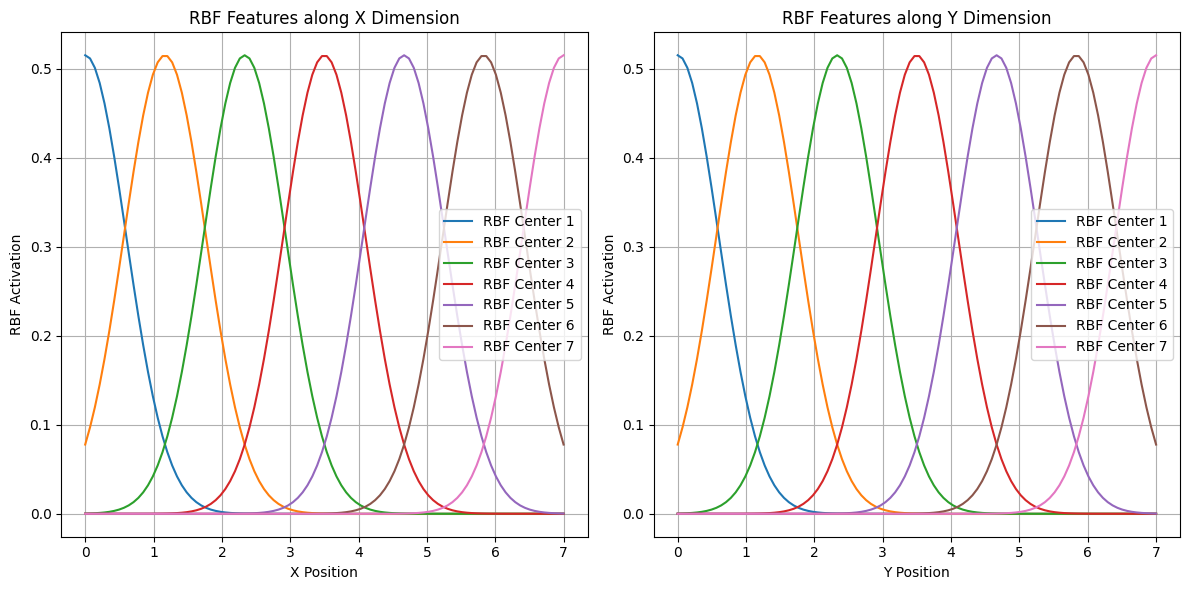

In [9]:
# Example usage:
num_basis = 7
grid_size = 7
std_dev = 0.6
amplitude = 1

# Create an instance of the RBF processor
rbf_processor = GWDataProcessorRBF(num_basis=num_basis, grid_size=grid_size, std_dev=std_dev)

# Plot the RBF features
plot_rbf_features(rbf_processor, amplitude=amplitude)

In [2]:
from copy import deepcopy
class Position:
    """Class implementing a position"""

    def __init__(self, x: float, y: float) -> None:
        """
        Args:
            x (int): x-axis coordinate
            y (int): y-axis coordinate
        """
        self.x = x
        self.y = y

LEGAL_OBS_TYPE = ["square", "circle", "sector"]


class Obstacle:
    """Class implementing an obstacle for the Continuous Grid World Env"""

    def __init__(self, type: str, features: dict):
        """
        Args:
            type (str): legal types in LEGAL_OBS_TYPE

            features (dict): a dictionary specifying what the obstacles seems
            to be. All the coordinates must be positions.
            If type is "SQUARE" -> 4 coordinates position of the polygon, with
            keys "p1", "p2", "p3", "p4" as:
                p4---------------p3
                |                               |
                |                              |
                p1---------------p2
            If type is "CIRCLE" -> "radius" and "center" coordinates
        """
        assert type in LEGAL_OBS_TYPE, "[ERROR] Illegal Ostacle type."
        self.type = type
        self.features = deepcopy(features)

        if self.type == "square":
            assert features["p1"].x == features["p4"].x
            assert features["p2"].x == features["p3"].x
            assert features["p1"].y == features["p2"].y
            assert features["p3"].y == features["p4"].y

    def is_in(self, pos: Position) -> bool:
        """
        Summary:
            Function saying if "pos" is in the obstacle

        Args:
            pos (Position): position to verify

        Returns:
            bool: flag saying if "pos" is inside the obstacle
        """
        res = False
        if self.type == "square":
            if (self.features["p1"].x <= pos.x <= self.features["p2"].x) and (self.features["p1"].y <= pos.y <= self.features["p4"].y):
                res = True
        elif self.type == "circle":
            dist = (pos.x - self.features["center"].x) ** 2
            dist += (pos.y - self.features["center"].y) ** 2
            dist = np.sqrt(dist)
            if dist <= self.features["radius"]:
                res = True
        else:
            pass
        return res

In [238]:
def design_u_obstacle(grid_size: int, size: float = 0.1) -> list:
    # Define the barycenter of the U-shape
    center_x = grid_size / 2
    center_y = grid_size / 2

    # Set dimensions for the U-shape
    horizontal_width = 3  # Width of the horizontal bottom edge
    vertical_height = 2   # Height of each vertical edge

    # Bottom horizontal edge of the U-shape, centered horizontally on the barycenter
    edge1 = Obstacle(
        type="square",
        features={
            "p1": Position(center_x - horizontal_width / 2, center_y - vertical_height / 2 - size),
            "p2": Position(center_x + horizontal_width / 2, center_y - vertical_height / 2 - size),
            "p3": Position(center_x + horizontal_width / 2, center_y - vertical_height / 2),
            "p4": Position(center_x - horizontal_width / 2, center_y - vertical_height / 2)
        }
    )

    # Left vertical edge of the U-shape, positioned to the left of the barycenter
    edge2 = Obstacle(
        type="square",
        features={
            "p1": Position(center_x - horizontal_width / 2, center_y - vertical_height / 2),
            "p2": Position(center_x - horizontal_width / 2 + size, center_y - vertical_height / 2),
            "p3": Position(center_x - horizontal_width / 2 + size, center_y + vertical_height / 2),
            "p4": Position(center_x - horizontal_width / 2, center_y + vertical_height / 2)
        }
    )

    # Right vertical edge of the U-shape, positioned to the right of the barycenter
    edge3 = Obstacle(
        type="square",
        features={
            "p1": Position(center_x + horizontal_width / 2 - size, center_y - vertical_height / 2),
            "p2": Position(center_x + horizontal_width / 2, center_y - vertical_height / 2),
            "p3": Position(center_x + horizontal_width / 2, center_y + vertical_height / 2),
            "p4": Position(center_x + horizontal_width / 2 - size, center_y + vertical_height / 2)
        }
    )

    return [edge1, edge2, edge3]


In [240]:
def cost_obstacle_continuous(position: Position, obstacles: list) -> float:
    """
    Compute the cost for a given position relative to the U-shaped obstacle.
    The cost is 1 at the axis of the obstacle and decreases smoothly to 0 at the obstacle's boundary.
    The U_axis is treated as continuous line segments.
    """
    # Define the U-axis as line segments
    U_axis = [
        [(2.25, 4.25), (2.25, 2.25)],  # Left vertical wall
        [(2.25, 2.25), (4.75, 2.25)],  # Bottom horizontal wall
        [(4.75, 2.25), (4.75, 4.25)]   # Right vertical wall
    ]

    is_in_obstacle = False
    costs = []

    # Check if the position is inside any of the obstacles
    for obs in obstacles:
        if obs.is_in(position):
            is_in_obstacle = True
            break

    # If inside an obstacle, calculate the cost based on the distance to the closest U-axis segment
    if is_in_obstacle:
        for segment in U_axis:
            (x1, y1), (x2, y2) = segment

            # Compute the projection of the position onto the line segment
            px, py = position.x, position.y
            dx, dy = x2 - x1, y2 - y1
            segment_length_squared = dx**2 + dy**2

            if segment_length_squared > 0:
                t = max(0, min(1, ((px - x1) * dx + (py - y1) * dy) / segment_length_squared))
                proj_x = x1 + t * dx
                proj_y = y1 + t * dy
            else:
                proj_x, proj_y = x1, y1  # If the segment is degenerate (zero length), use one endpoint

            # Compute the distance from the position to the closest point on the segment
            distance = np.sqrt((px - proj_x)**2 + (py - proj_y)**2)

            # Calculate the cost as a smooth decrease based on distance
            cost = max(1 - distance / 0.25, 0)  # Ensure cost is non-negative
            costs.append(cost)

    return max(costs) if costs else 0


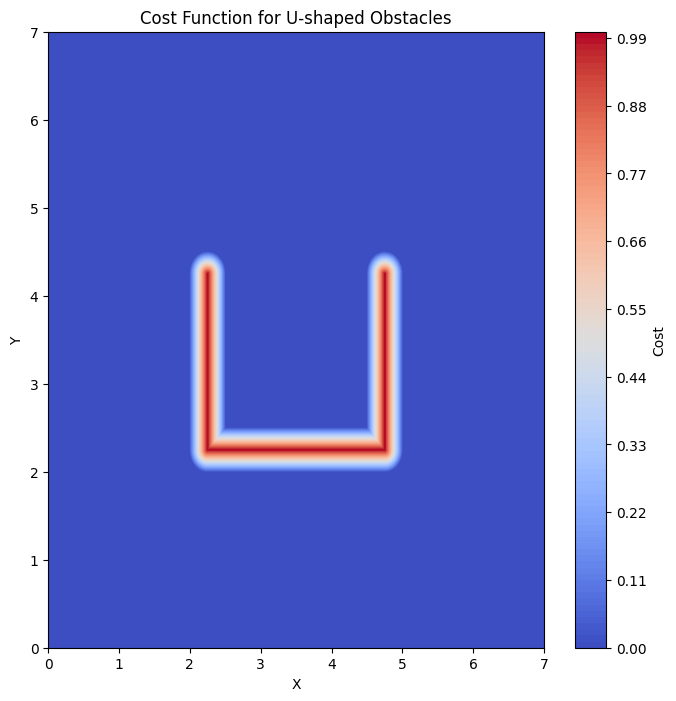

In [241]:
# Define the grid size and obstacles
grid_size = 7
obstacles = design_u_obstacle(grid_size, 0.5)

# Generate a grid of positions to evaluate the cost
x = np.linspace(0, grid_size, 1000)
y = np.linspace(0, grid_size, 1000)
X, Y = np.meshgrid(x, y)

# Compute the cost for each position
Z = np.zeros_like(X)
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        pos = Position(x=X[i, j], y=Y[i, j])
        Z[i, j] = cost_obstacle_continuous(pos, obstacles)

# Plot the cost function
plt.figure(figsize=(8, 8))
plt.contourf(X, Y, Z, levels=100, cmap='coolwarm')
plt.colorbar(label="Cost")
plt.title("Cost Function for U-shaped Obstacles")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()
